# Product categorization

Objectif: Regrouper des items en différentes catégories plus générales en se basant sur une analyse sémantique du contenu de la description.
Contrainte: La description ne fait que quelques mots, c'est une entête.
Un exemple d'application pourrait être un site d'échange/ventes entre particulier où le produit est décrit en qq mots par l'utilisateur. Ou alors des messages dont on n'aurait que le sujet, pas le corps du texte.

Le problème s'identifie à du topic modeling mais avec un texte (document) très court

- Exploration / formatage
- Approche Bag of words suivie d'un k-Means
- A pproche Latent Dirichlet Allocation
- Approches hybrides: guided LDA? Autres?

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import nltk

note: le fichier original a été lu en 'latin1' puis ré-encodé en 'utf-8' pour plus de simplicité

In [2]:
data = pd.read_csv('data/data.csv',index_col=0)

In [3]:
data.head(10)

,product_name
0,Appareil à chichis
1,dvd raiponce
2,Raquette de squash artengo sr 840
3,lunette astronomique
4,appareil à chaussons
5,Appareil à fondue au chocolat
6,Petit futé Italie du Nord 2013 - guide
7,Coupe ananas
8,8 flûtes à champagne
9,VTT


In [42]:
import nltk

In [43]:
stemmer = nltk.stem.SnowballStemmer("french")

In [53]:
doc = 'Appareil à chichis'

In [54]:
nltk.word_tokenize(doc)

['Appareil', 'à', 'chichis']

In [55]:
nltk.word_tokenize(doc.lower())

['appareil', 'à', 'chichis']

In [56]:
[stemmer.stem(m) for m in nltk.word_tokenize(doc.lower())]

['appareil', 'à', 'chich']

In [58]:
doc = 'appareil à chaussons'
[stemmer.stem(m) for m in nltk.word_tokenize(doc.lower())]

['appareil', 'à', 'chausson']

In [61]:
doc = 'l\'appareil à chaussons'
nltk.word_tokenize(doc.lower(), language='french')

["l'appareil", 'à', 'chaussons']

In [10]:
stemmer = nltk.stem.SnowballStemmer("french", ignore_stopwords=True)
doc = 'appareil à chaussons'
[stemmer.stem(m) for m in nltk.word_tokenize(doc.lower())]

['appareil', 'à', 'chausson']

In [9]:
stemmer = nltk.stem.SnowballStemmer("french", ignore_stopwords=False)
doc = 'appareil à chaussons'
[stemmer.stem(m) for m in nltk.word_tokenize(doc.lower())]

['appareil', 'à', 'chausson']

In [65]:
from nltk.corpus import stopwords
french_stopwords = set(stopwords.words('french'))
doc = 'appareil à chaussons'
[m for m in nltk.word_tokenize(doc.lower())
     if m.lower() not in french_stopwords]

['appareil', 'chaussons']

In [4]:
test_corpus = data.head(10)


In [5]:
test_corpus

,product_name
0,Appareil à chichis
1,dvd raiponce
2,Raquette de squash artengo sr 840
3,lunette astronomique
4,appareil à chaussons
5,Appareil à fondue au chocolat
6,Petit futé Italie du Nord 2013 - guide
7,Coupe ananas
8,8 flûtes à champagne
9,VTT


In [8]:
list(test_corpus['product_name'])

['Appareil à chichis',
 'dvd raiponce',
 'Raquette de squash artengo sr 840',
 'lunette astronomique',
 'appareil à chaussons',
 'Appareil à fondue au chocolat',
 'Petit futé Italie du Nord 2013 - guide',
 'Coupe ananas',
 '8 flûtes à champagne',
 'VTT']

In [18]:
def stemming_corpus(corpus):
    ## stemming corpus
    # le stemmer doit être appliqué sur des tokens
    # tous les mots des documents sont processés 
    # mais je conserve au final le format de corpus
    from nltk.corpus import stopwords
    french_stopwords = set(stopwords.words('french'))
    tokenizer = nltk.RegexpTokenizer(r'\b\w\w+\b')
    stemmer = stemmer = nltk.stem.SnowballStemmer("french")
    stemmed_corpus = []
    for doc in corpus:
        s = ' '
        stemmed_corpus.extend(
            [s.join([stemmer.stem(w) for w in tokenizer.tokenize(doc) 
                     if w.lower() not in french_stopwords])]
        )
    return(stemmed_corpus)


In [13]:
stemming_corpus(list(test_corpus['product_name']))

['appareil chich',
 'dvd raiponc',
 'raquet squash artengo sr 840',
 'lunet astronom',
 'appareil chausson',
 'appareil fondu chocolat',
 'pet fut ital nord 2013 guid',
 'coup anan',
 'flût champagn',
 'vtt']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df=0, max_df=0.95, # ignore termes présents ds plus 95% doc
                             ngram_range=(1, 2)) # si je veux considérer ts les unigrammes et tous les bigrammes
corpus = stemming_corpus(list(test_corpus['product_name']))
tfidf_vect.fit(corpus)

vocabulaire = tfidf_vect.vocabulary_
print('Vocabulary size: {}'.format(len(tfidf_vect.vocabulary_)))
print('10 first features:\n{}'.format(tfidf_vect.get_feature_names()[:10]))


Vocabulary size: 42
10 first features:
['2013', '2013 guid', '840', 'anan', 'appareil', 'appareil chausson', 'appareil chich', 'appareil fondu', 'artengo', 'artengo sr']


In [17]:
X_train = tfidf_vect.transform(corpus)

In [18]:
X_train

<10x42 sparse matrix of type '<class 'numpy.float64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [20]:
kmeans.labels_

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [21]:
test_corpus['labels'] = kmeans.labels_
test_corpus

C:\Users\Nicolas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,product_name,labels
0,Appareil à chichis,1
1,dvd raiponce,0
2,Raquette de squash artengo sr 840,0
3,lunette astronomique,0
4,appareil à chaussons,1
5,Appareil à fondue au chocolat,1
6,Petit futé Italie du Nord 2013 - guide,0
7,Coupe ananas,0
8,8 flûtes à champagne,0
9,VTT,0


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.95, # ignore termes présents ds plus 95% doc
                             ngram_range=(1, 2)) # si je veux considérer ts les unigrammes et tous les bigrammes
corpus = stemming_corpus(list(data['product_name']))
tfidf_vect.fit(corpus)

vocabulaire = tfidf_vect.vocabulary_
print('Vocabulary size: {}'.format(len(tfidf_vect.vocabulary_)))
print('10 first features:\n{}'.format(tfidf_vect.get_feature_names()[:10]))


Vocabulary size: 592
10 first features:
['1200', '14', '14 4v', '3d', '400w', '44', '4v', '6000', '6000 pro', '90']


In [23]:
X_train = tfidf_vect.transform(corpus)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train)

In [32]:
data.iloc[np.where(kmeans.labels_==0)].head(10)

,product_name
215,Scie sauteuse
227,Scie sauteuse
287,Scie sauteuse 350W
334,Scie Sauteuse
353,Scie sauteuse
378,Scie sauteuse
412,Scie sauteuse
486,Scie sauteuse Bosch PST 700 PE
523,Scie sauteuse
584,Scie sauteuse


In [33]:
data.iloc[np.where(kmeans.labels_==1)].head(10)

,product_name
0,Appareil à chichis
4,appareil à chaussons
16,Appareil à chichis
30,Appareil à raclette
31,appareil à raclette
45,Appareil a raclette 8 personnes
46,Appareil à raclette
74,Appareil à raclette
76,Appareil a raclette
97,Appareil à chichis


In [34]:
data.iloc[np.where(kmeans.labels_==2)].head(10)

,product_name
147,Ponceuse BOSCH
284,Ponceuse vibrante ROTOTECH
455,Ponceuse BOSCH
478,Ponceuse Bosch PSM 800 A
479,PONCEUSE TRIANGULAIRE
480,Ponceuse électrique
549,Ponceuse électrique
550,Ponceuse Bosh
583,Ponceuse électrique
687,Ponceuse BOSCH


In [35]:
data.iloc[np.where(kmeans.labels_==3)].head(10)

,product_name
141,Diable
245,Diable
352,Diable
361,Diable
411,Diable pliant
436,Diable
501,Diable
728,Diable pliable
738,Diable 3 roues
843,diable


In [36]:
data.iloc[np.where(kmeans.labels_==4)].head(10)

,product_name
1,dvd raiponce
2,Raquette de squash artengo sr 840
3,lunette astronomique
5,Appareil à fondue au chocolat
6,Petit futé Italie du Nord 2013 - guide
7,Coupe ananas
8,8 flûtes à champagne
9,VTT
10,Playstation 3
11,Mini laser


In [45]:
corpus[1:5]

['dvd raiponc',
 'raquet squash artengo sr 840',
 'lunet astronom',
 'appareil chausson']

In [51]:
np.where(kmeans.labels_==3)

(array([ 141,  245,  352,  361,  411,  436,  501,  728,  738,  843,  844,
         845,  846,  895,  896,  897,  988, 1069, 1120, 1121, 1122, 1181,
        1245, 1306, 1307, 1410, 1557, 1560, 1669, 1796, 1797, 1822, 1833,
        1837, 1839, 1840, 1841, 1842, 1844, 1973, 1986, 1987, 2018, 2023,
        2040, 2053, 2092, 2095, 2100, 2112, 2118, 2121, 2157, 2161, 2163,
        2173, 2174, 2177, 2315, 2320, 2321, 2341, 2453, 2519, 2563, 2678,
        2679, 2682, 2683, 2684, 2705, 2706, 2707, 2795, 2845, 2846, 2849,
        2870, 2871, 2885, 3104, 3105, 3106, 3137, 3211, 3262, 3279, 3296,
        3334, 3346, 3373, 3451, 3464, 3465, 3471, 3489, 3490, 3491, 3540,
        3621, 3636, 3637, 3661, 3672, 3673, 3674, 3818, 3819, 3853, 3894,
        3965, 3966, 3989, 3992, 3993, 3996, 3998, 3999, 4000, 4060, 4066,
        4067, 4128, 4341, 4391, 4392, 4430, 4465, 4485, 4486, 4487, 4488,
        4489, 4491, 4492, 4493, 4494, 4495, 4497, 4498, 4499, 4503, 4548,
        4618, 4620, 4656, 4658, 4682, 

In [52]:
corpus[kmeans.labels_==3]

TypeError: only integer scalar arrays can be converted to a scalar index

In [54]:
np.array([1,5])

array([1, 5])

In [55]:
tfidf_vect.inverse_transform(corpus[:10])

[array(['1200', '14', '14 4v', '3d', '400w', '44', '4v', '6000',
        '6000 pro', '90'], dtype='<U19')]

In [56]:
X_train

<5206x592 sparse matrix of type '<class 'numpy.float64'>'
	with 13651 stored elements in Compressed Sparse Row format>

In [57]:
X_train[np.where(kmeans.labels_==3)]

<164x592 sparse matrix of type '<class 'numpy.float64'>'
	with 171 stored elements in Compressed Sparse Row format>

In [58]:
tfidf_vect.inverse_transform(X_train[np.where(kmeans.labels_==3)])

[array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl', 'pli'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl', 'pliabl'], dtype='<U19'),
 array(['diabl', 'rou'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl', 'pli'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl', 'déménag'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 array(['diabl'], dtype='<U19'),
 

In [69]:
tfidf_vect.inverse_transform(X_train[np.where(kmeans.labels_==3)])[4][0:]

array(['diabl', 'pli'], dtype='<U19')

In [73]:
[w[0] for w in tfidf_vect.inverse_transform(X_train[np.where(kmeans.labels_==3)])]

['diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',
 'diabl',


In [74]:
[w for w in tfidf_vect.inverse_transform(X_train[np.where(kmeans.labels_==3)])[4]]

['diabl', 'pli']

In [5]:
from wordcloud import WordCloud

In [7]:
data['product_name'][0]

'Appareil à chichis'

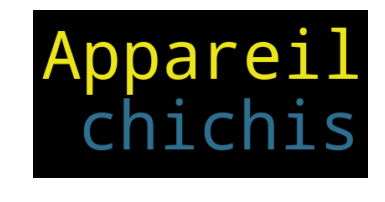

In [8]:
wordcloud = WordCloud().generate(data['product_name'][0])
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
texte = ' '.join(data['product_name'])
texte

'Appareil à chichis dvd raiponce Raquette de squash artengo sr 840 lunette astronomique appareil à chaussons Appareil à fondue au chocolat Petit futé Italie du Nord 2013 - guide Coupe ananas 8 flûtes à champagne VTT Playstation 3 Mini laser Appareil photo nikon coolpix taille crayon à légumes Aille de traction 4,5m2 tribord zeruko élastique de musculation Appareil à chichis Fall of Giants - Ken Follet vidéo projecteur HITACHI blender thomson 500w Superbe bateau en carton Nettoyeur vitres Nettoyeur haute pression Noeud papillion paire de ski coreupt candide pow 175cm hachoir à viande matelas gonflable 2 pers Perceuse carnet de chant : diapason Rouge 2 tapis de sol décathelon qui se gonfle Appareil à raclette appareil à raclette Projecteur halogene Jeu de société Mixmo Blender Kenwood Les Héritiers d\'Enkidiev Bequilles perceuse Appareil à crêpes Les Secrets de l\'Immortel Nicolas Flamel pied mixeur 6 flutes de champagne en plastique enlève joint raquette de tennis Costume carnaval de Du

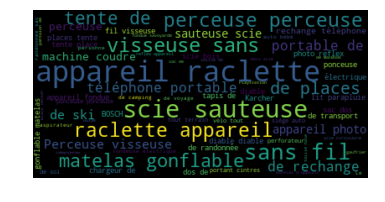

In [11]:
wordcloud = WordCloud().generate(texte)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
toto = pd.DataFrame(columns = ['racine', 'générique', 'occurence'])
toto

,racine,générique,occurence


In [21]:
'ah' in toto['racine']

False

In [25]:
min(['ah','ahah'])

'ah'

In [30]:
toto.shape

(0, 3)

In [31]:
toto.iloc[0]

IndexError: single positional indexer is out-of-bounds

In [61]:
from nltk.corpus import stopwords
french_stopwords = set(stopwords.words('french'))
tokenizer = nltk.RegexpTokenizer(r'\b\w\w+\b')
stemmer = stemmer = nltk.stem.SnowballStemmer("french")

df = pd.DataFrame(np.array([['na','na',0]]),columns = ['racine', 'générique', 'occurence'])

for word in tokenizer.tokenize(texte):
    if word in french_stopwords: continue
    racine = stemmer.stem(word)
    if racine in df['racine'].values:
        df[df.racine==racine]['occurence']+=1
        generique = min([word, df[df.racine==racine].loc['générique']])
        df[df.racine==racine]['générique'] = generique
    else:
        tmp = pd.DataFrame(np.array([[racine,word,1]]), columns = ['racine', 'générique', 'occurence'])
        df = df.append(tmp)


TypeError: must be str, not int

In [62]:
df

,racine,générique,occurence
0,na,na,0
0,appareil,Appareil,1
0,chich,chichis,1
0,dvd,dvd,1
0,raiponc,raiponce,1
0,raquet,Raquette,1
0,squash,squash,1
0,artengo,artengo,1
0,sr,sr,1
0,840,840,1


In [63]:
df['occurence']

0    0
0    1
0    1
0    1
0    1
0    1
0    1
0    1
0    1
0    1
0    1
0    1
Name: occurence, dtype: object

In [59]:
'appareil' in df['racine'].values

True

In [58]:
df['racine'].values

array(['appareil', 'chich', 'dvd', ..., 'circulair', 'bosch', '600w'],
      dtype=object)

In [55]:
df[df.racine=='appareil']

,racine,générique,occurence
0,appareil,Appareil,1
0,appareil,appareil,1
0,appareil,Appareil,1
0,appareil,Appareil,1
0,appareil,Appareil,1
0,appareil,Appareil,1
0,appareil,appareil,1
0,appareil,Appareil,1
0,appareil,Appareil,1
0,appareil,Appareil,1


In [54]:
df.head(10)

,racine,générique,occurence
0,appareil,Appareil,1
0,chich,chichis,1
0,dvd,dvd,1
0,raiponc,raiponce,1
0,raquet,Raquette,1
0,squash,squash,1
0,artengo,artengo,1
0,sr,sr,1
0,840,840,1
0,lunet,lunette,1


In [35]:
word = tokenizer.tokenize(texte)[0]
word

'Appareil'

In [36]:
word in french_stopwords

False

In [37]:
racine = stemmer.stem(word)
racine

'appareil'

In [38]:
df

,racine,générique,occurence


In [39]:
racine in df['racine']

False

In [45]:
tmp = pd.DataFrame({'racine':[racine], 'générique':[word], 'occurence':[1]})
tmp

,générique,occurence,racine
0,Appareil,1,appareil


In [47]:
tmp = pd.DataFrame(np.array([[racine,word,1]]), columns = ['racine', 'générique', 'occurence'])
tmp

,racine,générique,occurence
0,appareil,Appareil,1


In [66]:
from nltk.corpus import stopwords
french_stopwords = set(stopwords.words('french'))
tokenizer = nltk.RegexpTokenizer(r'\b\w\w+\b')
stemmer = stemmer = nltk.stem.SnowballStemmer("french")

racine_kw = {}
count_kw = {}

for word in tokenizer.tokenize(texte):
    word = word.lower()
    if word in french_stopwords: continue
    racine = stemmer.stem(word)
    if racine in racine_kw:
        racine_kw[racine].add(word)
        count_kw[racine] += 1
    else:
        racine_kw[racine] = {word}
        count_kw[racine] = 1


In [67]:
racine_kw

{'appareil': {'appareil'},
 'chich': {'chichis'},
 'dvd': {'dvd'},
 'raiponc': {'raiponce'},
 'raquet': {'raquette', 'raquettes'},
 'squash': {'squash'},
 'artengo': {'artengo'},
 'sr': {'sr'},
 '840': {'840'},
 'lunet': {'lunette', 'lunettes'},
 'astronom': {'astronomique'},
 'chausson': {'chausson', 'chaussons'},
 'fondu': {'fondue'},
 'chocolat': {'chocolat'},
 'pet': {'peter', 'petit'},
 'fut': {'futé'},
 'ital': {'italie'},
 'nord': {'nord'},
 '2013': {'2013'},
 'guid': {'guide', 'guides'},
 'coup': {'coupante', 'coupe'},
 'anan': {'ananas'},
 'flût': {'flûtes'},
 'champagn': {'champagne'},
 'vtt': {'vtt'},
 'playstat': {'playstation'},
 'min': {'mini'},
 'las': {'laser'},
 'photo': {'photo'},
 'nikon': {'nikon'},
 'coolpix': {'coolpix'},
 'taill': {'taille'},
 'crayon': {'crayon'},
 'légum': {'légumes'},
 'aill': {'aille'},
 'traction': {'traction'},
 '5m2': {'5m2'},
 'tribord': {'tribord'},
 'zeruko': {'zeruko'},
 'élast': {'élastique'},
 'muscul': {'musculation'},
 'fall': {'fa

In [68]:
count_kw

{'appareil': 449,
 'chich': 4,
 'dvd': 6,
 'raiponc': 1,
 'raquet': 35,
 'squash': 4,
 'artengo': 2,
 'sr': 3,
 '840': 2,
 'lunet': 2,
 'astronom': 1,
 'chausson': 2,
 'fondu': 63,
 'chocolat': 11,
 'pet': 8,
 'fut': 3,
 'ital': 1,
 'nord': 1,
 '2013': 1,
 'guid': 23,
 'coup': 12,
 'anan': 1,
 'flût': 2,
 'champagn': 2,
 'vtt': 8,
 'playstat': 30,
 'min': 16,
 'las': 19,
 'photo': 84,
 'nikon': 9,
 'coolpix': 2,
 'taill': 29,
 'crayon': 1,
 'légum': 5,
 'aill': 1,
 'traction': 1,
 '5m2': 1,
 'tribord': 1,
 'zeruko': 1,
 'élast': 2,
 'muscul': 2,
 'fall': 1,
 'of': 2,
 'gi': 1,
 'ken': 2,
 'follet': 2,
 'vidéo': 10,
 'projecteur': 14,
 'hitach': 5,
 'blend': 21,
 'thomson': 1,
 '500w': 1,
 'superb': 1,
 'bateau': 1,
 'carton': 1,
 'nettoyeur': 30,
 'vitr': 5,
 'haut': 14,
 'pression': 12,
 'noeud': 1,
 'papillion': 1,
 'pair': 9,
 'ski': 85,
 'coreupt': 4,
 'candid': 4,
 'pow': 4,
 '175cm': 4,
 'hachoir': 3,
 'viand': 3,
 'matel': 165,
 'gonflabl': 160,
 'per': 11,
 'perceux': 420,
 'ca

In [73]:
rac = []
occ = []
gen = []
for r in racine_kw.keys():
    rac.extend([r])
    occ.extend([count_kw[r]])
    gen.extend([min(racine_kw[r])])

In [74]:
rac

['appareil',
 'chich',
 'dvd',
 'raiponc',
 'raquet',
 'squash',
 'artengo',
 'sr',
 '840',
 'lunet',
 'astronom',
 'chausson',
 'fondu',
 'chocolat',
 'pet',
 'fut',
 'ital',
 'nord',
 '2013',
 'guid',
 'coup',
 'anan',
 'flût',
 'champagn',
 'vtt',
 'playstat',
 'min',
 'las',
 'photo',
 'nikon',
 'coolpix',
 'taill',
 'crayon',
 'légum',
 'aill',
 'traction',
 '5m2',
 'tribord',
 'zeruko',
 'élast',
 'muscul',
 'fall',
 'of',
 'gi',
 'ken',
 'follet',
 'vidéo',
 'projecteur',
 'hitach',
 'blend',
 'thomson',
 '500w',
 'superb',
 'bateau',
 'carton',
 'nettoyeur',
 'vitr',
 'haut',
 'pression',
 'noeud',
 'papillion',
 'pair',
 'ski',
 'coreupt',
 'candid',
 'pow',
 '175cm',
 'hachoir',
 'viand',
 'matel',
 'gonflabl',
 'per',
 'perceux',
 'carnet',
 'chant',
 'diapason',
 'roug',
 'tapis',
 'sol',
 'décathelon',
 'gonfl',
 'raclet',
 'halogen',
 'jeu',
 'societ',
 'mixmo',
 'kenwood',
 'le',
 'hériti',
 'enkidiev',
 'bequill',
 'crêp',
 'secret',
 'immortel',
 'nicol',
 'flamel',
 '

In [75]:
gen

['appareil',
 'chichis',
 'dvd',
 'raiponce',
 'raquette',
 'squash',
 'artengo',
 'sr',
 '840',
 'lunette',
 'astronomique',
 'chausson',
 'fondue',
 'chocolat',
 'peter',
 'futé',
 'italie',
 'nord',
 '2013',
 'guide',
 'coupante',
 'ananas',
 'flûtes',
 'champagne',
 'vtt',
 'playstation',
 'mini',
 'laser',
 'photo',
 'nikon',
 'coolpix',
 'taille',
 'crayon',
 'légumes',
 'aille',
 'traction',
 '5m2',
 'tribord',
 'zeruko',
 'élastique',
 'musculation',
 'fall',
 'of',
 'giants',
 'ken',
 'follet',
 'vidéo',
 'projecteur',
 'hitachi',
 'blender',
 'thomson',
 '500w',
 'superbe',
 'bateau',
 'carton',
 'nettoyeur',
 'vitre',
 'haute',
 'pression',
 'noeud',
 'papillion',
 'paire',
 'ski',
 'coreupt',
 'candide',
 'pow',
 '175cm',
 'hachoir',
 'viande',
 'matela',
 'gonflable',
 'pers',
 'perceuse',
 'carnet',
 'chant',
 'diapason',
 'rouge',
 'tapis',
 'sol',
 'décathelon',
 'gonflant',
 'raclette',
 'halogene',
 'jeu',
 'société',
 'mixmo',
 'kenwood',
 'les',
 'héritiers',
 'enki

In [76]:
occ

[449,
 4,
 6,
 1,
 35,
 4,
 2,
 3,
 2,
 2,
 1,
 2,
 63,
 11,
 8,
 3,
 1,
 1,
 1,
 23,
 12,
 1,
 2,
 2,
 8,
 30,
 16,
 19,
 84,
 9,
 2,
 29,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 10,
 14,
 5,
 21,
 1,
 1,
 1,
 1,
 1,
 30,
 5,
 14,
 12,
 1,
 1,
 9,
 85,
 4,
 4,
 4,
 4,
 3,
 3,
 165,
 160,
 11,
 420,
 2,
 1,
 1,
 6,
 45,
 38,
 1,
 3,
 310,
 2,
 36,
 16,
 1,
 2,
 15,
 1,
 1,
 1,
 26,
 1,
 1,
 1,
 1,
 11,
 25,
 1,
 1,
 1,
 2,
 17,
 9,
 1,
 1,
 40,
 23,
 2,
 13,
 1,
 1,
 1,
 34,
 35,
 149,
 4,
 34,
 1,
 18,
 35,
 7,
 7,
 2,
 3,
 6,
 3,
 1,
 1,
 1,
 7,
 1,
 27,
 105,
 1,
 2,
 1,
 5,
 5,
 6,
 3,
 3,
 2,
 2,
 2,
 30,
 3,
 2,
 19,
 1,
 1,
 25,
 2,
 1,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 4,
 1,
 1,
 6,
 3,
 1,
 1,
 1,
 12,
 55,
 1,
 1,
 13,
 11,
 12,
 16,
 3,
 2,
 1,
 1,
 5,
 28,
 5,
 6,
 63,
 24,
 17,
 12,
 2,
 1,
 1,
 6,
 9,
 28,
 9,
 61,
 1,
 2,
 1,
 13,
 17,
 33,
 1,
 1,
 1,
 1,
 5,
 4,
 236,
 33,
 12,
 9,
 3,
 69,
 1,
 91,
 1,
 1,
 1,
 11,
 4,
 198,
 5,
 25,
 139,
 69,
 20,
 14,


In [81]:
df = pd.DataFrame({'racine':rac, 'générique':gen, 'occurence':occ})
df

,générique,occurence,racine
0,appareil,449,appareil
1,chichis,4,chich
2,dvd,6,dvd
3,raiponce,1,raiponc
4,raquette,35,raquet
5,squash,4,squash
6,artengo,2,artengo
7,sr,3,sr
8,840,2,840
9,lunette,2,lunet


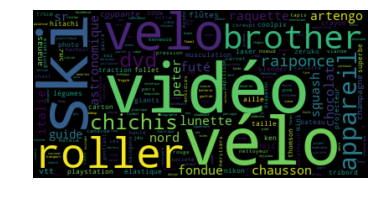

In [89]:
test = ' '.join(df['générique'])
wordcloud = WordCloud().generate(test)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [107]:
test = ''
for i in df.index:
    tmp = ' '.join([df.iloc[i]['générique']]*df.iloc[i]['occurence'])
    test = ' '.join([test,tmp])
test

' appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil appareil

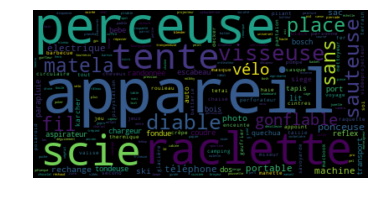

In [111]:
# collocations=False pour éviter qu'il ne considère des paires de mots fréquentes
wordcloud = WordCloud(collocations=False).generate(test)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [88]:
df.sort_values(by=['occurence'], ascending=False)

,générique,occurence,racine
0,appareil,449,appareil
72,perceuse,420,perceux
81,raclette,310,raclet
299,scie,290,sci
209,tente,236,tent
340,visseuse,208,visseux
222,diable,198,diabl
300,sauteuse,196,sauteux
277,place,176,plac
69,matela,165,matel


<Container object of 10 artists>

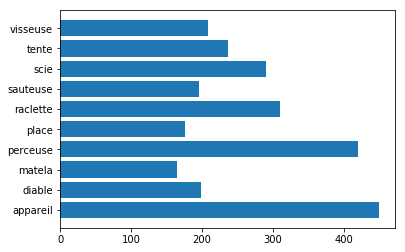

In [120]:
tmp = df.sort_values(by=['occurence'], ascending=False)
tmp = tmp[:10]
xx = tmp['générique'].values
yy = tmp['occurence'].values
plt.barh(xx,yy)

In [121]:
xx


array(['appareil', 'perceuse', 'raclette', 'scie', 'tente', 'visseuse',
       'diable', 'sauteuse', 'place', 'matela'], dtype=object)

<Container object of 3 artists>

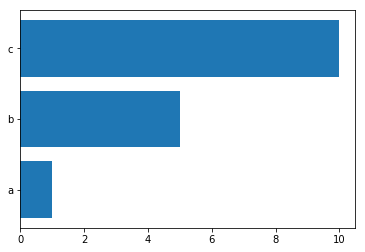

In [122]:
plt.barh(['a', 'c', 'b'], [1,10,5])

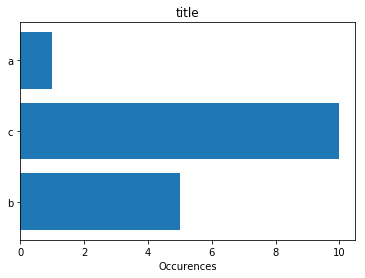

In [123]:
fig, ax = plt.subplots()
xx = ['a', 'c', 'b']
yy = [1,10,5]
y_pos = np.arange(len(xx))

ax.barh(y_pos, yy)
ax.set_yticks(y_pos)
ax.set_yticklabels(xx)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurences')
ax.set_title('title')

plt.show()

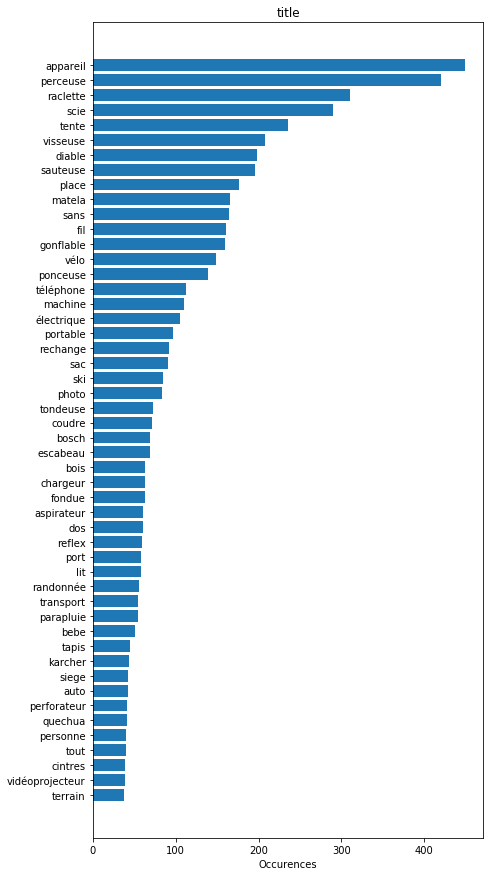

In [129]:
fig, ax = plt.subplots(figsize=(7, 15))

tmp = df.sort_values(by=['occurence'], ascending=False)
tmp = tmp[:50]
xx = tmp['générique'].values
yy = tmp['occurence'].values

y_pos = np.arange(len(xx))

ax.barh(y_pos, yy)
ax.set_yticks(y_pos)
ax.set_yticklabels(xx)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurences')
ax.set_title('title')

plt.show()